In [1]:
"""
1. dataset of sentences to overall sentiment
2. create a model from dataset of word to sentiment
2.5 gramatically break down sentence instead of word by word
3. use model for our own sentence input to output overall sentiment of sentence
3.5 if a word is not known --> do sentiment analysis on its dictionary definition or neutralize
"""

'\n1. dataset of sentences to overall sentiment\n2. create a model from dataset of word to sentiment\n2.5 gramatically break down sentence instead of word by word\n3. use model for our own sentence input to output overall sentiment of sentence\n3.5 if a word is not known --> do sentiment analysis on its dictionary definition or neutralize\n'

In [1]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
import nltk.data

lm = WordNetLemmatizer()

In [21]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fdwraith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fdwraith/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
col_names = ["sentiment", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(
    'training.1600000.processed.noemoticon.csv',
    header=None, encoding="ISO-8859-1", names=col_names)

# normalize to 0 to 1 values
df['sentiment'] = df['sentiment'].replace(4, 1)

X_train, X_test, y_train, y_test = train_test_split(df, df['sentiment'], test_size = 0.10, random_state=0)

df = X_test

In [3]:
NEGATION_WORDS = ['not', 'no']
STOP_WORDS = stopwords.words('english')

for word in NEGATION_WORDS:
    STOP_WORDS.remove(word)

URL_PATTERN = r'((https://[^ ]*|(http://)[^ ]*|( www\.)[^ ]*))'
USER_PATTERN = '@[^\s]+'
PUNCTUATIONS = ['!', '?']

processed = []
for sentiment, tweet in zip(df['sentiment'], df['text']):
    tweet = tweet.lower()
    tweet = re.sub(URL_PATTERN, '', tweet)
    tweet = re.sub(USER_PATTERN, '', tweet)
    for p in PUNCTUATIONS:
        tweet = tweet.replace(p, '')
    for sw in STOP_WORDS:
        tweet = re.sub(r'\b{0}\b'.format(sw), '', tweet)
    for w in NEGATION_WORDS:
        tweet = re.sub(r'\b{0} \b'.format(w), '{0}_'.format(w), tweet)
        
    processed.append((sentiment, tweet))    
    
df = pd.DataFrame(data=processed, columns=['sentiment', 'tweet'])

df

,sentiment,tweet
0,0,wants compete want hard competition want r...
1,0,seems stuck ground amarillo. put grou...
2,0,f pinking shears rarararrrarararr...babypr...
3,0,0ff t0 meetin.. hate ppl v0lunteer free t...
4,1,@ reply pls
...,...,...
159995,0,"got back, think ' different"
159996,0,aw sylar' lost poor baby wanna help ' cryin...
159997,0,home please
159998,1,quite loud came nowhere. laughed


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, df['sentiment'], test_size = 0.05, random_state=0)

model = {}
for sentiment, tweet in zip(X_train['sentiment'], X_train['tweet']):
    for word in tweet.split():
        word = lm.lemmatize(word)
        if word in model:
            count, avg = model[word]
            model[word] = (count+1, (count*avg+sentiment) / (count+1))
        else:
            model[word] = (1, sentiment)
                        
model

{'hello': (468, 0.7948717948717947),
 '=': (557, 0.49371633752244165),
 "'": (49575, 0.4420776601109432),
 'big': (938, 0.5383795309168449),
 'fan': (505, 0.6475247524752479),
 'speak': (105, 0.6380952380952378),
 'little': (1504, 0.5099734042553193),
 'french': (177, 0.4632768361581921),
 'feel': (3269, 0.2792903028449062),
 'extreeemely': (1, 0),
 'sick': (1199, 0.08173477898248536),
 'way': (1932, 0.5155279503105592),
 'much': (3048, 0.454724409448819),
 'homework.': (52, 0.28846153846153844),
 'no_3d': (3, 0.0),
 'movie': (1266, 0.6516587677725132),
 'fun': (2098, 0.6930409914203997),
 'sun': (838, 0.49522673031026254),
 'today': (4394, 0.46495220755575767),
 'tummy': (192, 0.08333333333333337),
 'hurt': (941, 0.07757704569606805),
 'say': (1877, 0.5412892914224815),
 'crazy': (457, 0.5229759299781181),
 'weather': (849, 0.3957597173144875),
 'making': (751, 0.5033288948069252),
 'sick.': (178, 0.07865168539325848),
 '-': (6576, 0.6221107055961075),
 'happy': (2237, 0.8113544926240

In [5]:
transition_prob = {
    'neg': { 'pos': 0, 'neg': 0 },
    'pos': { 'pos': 0, 'neg': 0 }
}
emission_prob = {
    'neg': { },
    'pos': { }
}

def state_to_num(s):
    return 1 if s == 'pos' else 0

def num_to_state(n):
    return 'pos' if n >= 0.5 else 'neg'

for sentiment, tweet in zip(X_train['sentiment'], X_train['tweet']):
    words = [lm.lemmatize(word) for word in tweet.split()]
    
    for i in range(len(words)): 
        word = words[i]
        
        # transition stuff
        #if i != 0:
        #    val = model[word][1]
        #    current_state = num_to_state(val)
        #    previous_state = num_to_state(model[words[i-1]][1])
        #    
        #    transition_prob[previous_state][current_state] += 1
        
        actual_state = num_to_state(sentiment)    
        word_state = num_to_state(model[word][1])
        
        # transition stuff
        transition_prob[word_state][actual_state] += 1        
    
        # emission stuff
        if word not in emission_prob[actual_state]:
            emission_prob['pos'][word] = 0
            emission_prob['neg'][word] = 0
        emission_prob[actual_state][word] += 1

def normalize(d):
    mult = 1.0/sum(d.values())
    for key in d:
        d[key] *= mult    
        
# normalize -- subtract mean and divide by std
# min-max scaling
# add-one smoothing for naive bayes
            
# normalize values in transition
normalize(transition_prob['pos'])
normalize(transition_prob['neg'])
# normalize value in emission
normalize(emission_prob['pos'])
normalize(emission_prob['neg'])

(transition_prob, emission_prob)

({'neg': {'pos': 0.34169243430251606, 'neg': 0.6583075656974839},
  'pos': {'pos': 0.6573170982499238, 'neg': 0.34268290175007615}},
 {'neg': {'hello': 0.00016127487790987757,
   '=': 0.00047374495386026536,
   "'": 0.04646564425113858,
   'big': 0.0007274168972393436,
   'fan': 0.0002990305027912313,
   'speak': 6.383797250599321e-05,
   'little': 0.0012381206772872893,
   'french': 0.000159594931264983,
   'feel': 0.003957954295371578,
   'extreeemely': 1.679946644894558e-06,
   'sick': 0.0018496212560289084,
   'way': 0.0015724300596213063,
   'much': 0.0027920713238147555,
   'homework.': 6.215802586109865e-05,
   'no_3d': 5.039839934683674e-06,
   'movie': 0.0007408564703985001,
   'fun': 0.0010818856393120953,
   'sun': 0.000710617430790398,
   'today': 0.003949554562147106,
   'tummy': 0.0002956706095014422,
   'hurt': 0.0014581936877684765,
   'say': 0.0014464340612542145,
   'crazy': 0.0003662283685870137,
   'weather': 0.0008618126288309082,
   'making': 0.0006266200985456701

In [6]:
ratios = { }     
for sentiment, tweet in zip(X_train['sentiment'], X_train['tweet']):
    words = [lm.lemmatize(word) for word in tweet.split()]
    vals = [model[word][1] for word in words if word in model]
    
    pos_count = len(list(filter(lambda v : v >= 0.5, vals)))
    neg_count = len(list(filter(lambda v : v < 0.5, vals)))
    
    ratio = 0.5 if (pos_count + neg_count) == 0 else round(pos_count * 1.0 / (pos_count + neg_count), 3)
    
    if ratio in ratios:
        count, avg = ratios[ratio]
        ratios[ratio] = (count+1, (count*avg+sentiment) / (count+1))
    else:
        ratios[ratio] = (1, sentiment)

ratios

{0.625: (1749, 0.7804459691252151),
 0.231: (671, 0.08792846497764525),
 0.6: (4517, 0.745627628957272),
 0.778: (978, 0.9498977505112475),
 0.429: (2995, 0.414357262103506),
 0.417: (1121, 0.3835860838537019),
 0.2: (4324, 0.13482886216466228),
 0.375: (2309, 0.30229536595928985),
 0.222: (1453, 0.11837577426015135),
 0.9: (465, 0.9935483870967742),
 0.0: (15342, 0.09281710337635267),
 0.571: (2798, 0.6887062187276627),
 0.143: (2005, 0.07231920199501263),
 0.8: (3185, 0.9284144427001567),
 0.857: (1285, 0.9688715953307393),
 0.25: (6356, 0.18895531780994315),
 0.3: (1383, 0.17498192335502522),
 0.5: (15450, 0.5762459546925581),
 0.467: (482, 0.4253112033195022),
 0.462: (872, 0.45298165137614677),
 0.667: (8344, 0.8142377756471726),
 1.0: (12849, 0.9553272628220095),
 0.583: (936, 0.739316239316239),
 0.438: (321, 0.34890965732087204),
 0.267: (442, 0.1085972850678733),
 0.75: (5100, 0.8931372549019592),
 0.083: (318, 0.015723270440251565),
 0.455: (1218, 0.4852216748768473),
 0.167:

In [7]:
def estimator(tweet):
    words = [lm.lemmatize(word) for word in tweet.split()]
    vals = [model[word][1] for word in words if word in model]
    
    if len(vals) == 0:
        return 0.5
    
    return sum(vals)/len(vals)

def approximate_ratio(ratio):
    rkeys = sorted(ratios.keys())

    if ratio < rkeys[0]:
        return ratios[rkeys[0]][1]
    
    if ratio > rkeys[-1]:
        return ratios[rkeys[-1]][1]
    
    l = 0
    while ratio > rkeys[l]:
        l += 1
                      
    return (ratios[rkeys[l]][1] + ratios[rkeys[l+1]][1])/2

def ratio_estimator(tweet):
    words = [lm.lemmatize(word) for word in tweet.split()]
    vals = [model[word][1] for word in words if word in model]
    
    pos_count = len(list(filter(lambda v : v >= 0.5, vals)))
    neg_count = len(list(filter(lambda v : v < 0.5, vals)))
    
    ratio = 0.5 if (pos_count + neg_count) == 0 else round(pos_count * 1.0 / (pos_count + neg_count), 3)
    
    if ratio not in ratios:
        return approximate_ratio(ratio)
        #ratios[ratio] = (1, approximate_ratio(ratio))
        
    return ratios[ratio][1]

def hmm_estimator(tweet):
    words = [lm.lemmatize(word) for word in tweet.split()]
    
    tr = transition_prob
    em = emission_prob
       
    gl = { 'pos': 0.5, 'neg': 0.5 }

    for i in range(len(words)):
        word = words[i]
        if word not in model:
            continue
            
        word_state = num_to_state(model[word][1])
        
        pr = {
            'pos': tr['pos']['pos'] * gl['pos'] + tr['neg']['pos'] * gl['neg'],
            'neg': tr['pos']['neg'] * gl['pos'] + tr['neg']['neg'] * gl['neg']
        }
        
        gl['pos'] = em['pos'][word] * pr['pos']
        gl['neg'] = em['neg'][word] * pr['neg']
        
        # just doing this results in 69% accuracy.. but not sure if this is right.
        #gl['pos'] = tr[word_state]['pos'] * gl['pos']
        #gl['neg'] = tr[word_state]['neg'] * gl['neg']
        
        normalize(gl)
    
    return gl['pos']

sentiment_pairs = []
for sentiment, tweet in zip(X_test['sentiment'], X_test['tweet']):
    estimated_sentiment = estimator(tweet)
    sentiment_pairs.append((sentiment, estimated_sentiment))
                      
ratio_sentiment_pairs = []
for sentiment, tweet in zip(X_test['sentiment'], X_test['tweet']):
    estimated_sentiment = ratio_estimator(tweet)
    ratio_sentiment_pairs.append((sentiment, estimated_sentiment))
    
hmm_sentiment_pairs = []
for sentiment, tweet in zip(X_test['sentiment'], X_test['tweet']):
    estimated_sentiment = hmm_estimator(tweet)
    hmm_sentiment_pairs.append((sentiment, estimated_sentiment))

sentiment_pairs

[(0, 0.35868483002617985),
 (0, 0.41925500326677656),
 (0, 0.4662914860418596),
 (1, 0.5797434297483333),
 (0, 0.5662721187895),
 (1, 0.6648728645009727),
 (0, 0.46625237603387915),
 (0, 0.4624097561412345),
 (0, 0.7669172932330827),
 (1, 0.6192110422933382),
 (1, 0.6239192671642745),
 (0, 0.4933120177738911),
 (1, 0.5239801854081123),
 (1, 0.5906489895399619),
 (0, 0.5326633241707551),
 (0, 0.5),
 (1, 0.5425493649558575),
 (0, 0.3469086064311326),
 (0, 0.5280797101449275),
 (0, 0.5891428613539477),
 (0, 0.45282156502185505),
 (0, 0.292938180391501),
 (0, 0.4548085768795082),
 (0, 0.5659193094659466),
 (0, 0.4122099371871064),
 (0, 0.49435760575478693),
 (0, 0.5026380782213501),
 (1, 0.6016581056426642),
 (0, 0.6242316307316494),
 (0, 0.4764563915180529),
 (0, 0.44011226309086343),
 (0, 0.5314009661835749),
 (1, 0.5326183907091232),
 (0, 0.38368811771804257),
 (1, 0.5650971397733406),
 (1, 0.5446286438966246),
 (0, 0.4650159129522602),
 (1, 0.483769137313916),
 (0, 0.5916761963004087),

In [8]:
def compute_errors(sentiment_pairs):
    errors = [abs(est - sent) for (sent, est) in sentiment_pairs]
    avg_error = sum(errors)/len(errors)
    var_values = [(error - avg_error)**2 for error in errors]
    variance = sum(var_values)/len(var_values)

    return (avg_error, variance)
    
def rounded_pairs(sentiment_pairs):
    return [(sent, 0 if est < 0.5 else 1) for (sent, est) in sentiment_pairs]

def compute_accuracy(rounded_sentiment_pairs):
    return len([1 for (sent, est) in rounded_sentiment_pairs if sent == est]) / len(rounded_sentiment_pairs)

In [9]:
def print_results(pairs):
    avg_error, variance = compute_errors(pairs)
    accuracy = compute_accuracy(rounded_pairs(pairs))

    print('Accuracy:', accuracy)
    print('Average Error:', avg_error)
    print('Variance:', variance)

print('Bayes Estimator')
print_results(sentiment_pairs)

print('-----------')

print('Ratio Estimator')
print_results(ratio_sentiment_pairs)

print('-----------')

print('HMM Estimator')
print_results(hmm_sentiment_pairs)

Bayes Estimator
Accuracy: 0.737125
Average Error: 0.44348567355629465
Variance: 0.009633594264877235
-----------
Ratio Estimator
Accuracy: 0.703375
Average Error: 0.3551298167828048
Variance: 0.07661263531823007
-----------
HMM Estimator
Accuracy: 0.678
Average Error: 0.4166465854348977
Variance: 0.04015480449984972


In [12]:
import nltk.data

def read_file(filename='test.txt'):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    fp = open(filename)
    data = fp.read()
    paragraphs = data.split('\n\n')
    return [ '\n-----\n'.join(tokenizer.tokenize(paragraph)).split('\n-----\n') for paragraph in paragraphs ]

def estimate_values(paragraph_sentences, estimator='estimator'):
    paragraph_values = [ [ globals()[estimator](sentence) for sentence in paragraph ] for paragraph in paragraph_sentences ]
    return [ sum(paragraph)/len(paragraph) for paragraph in paragraph_values ]

In [22]:
trump_speech = read_file(filename='test.txt')
obama_speech = read_file(filename='obama.txt')

trump_naive_values = estimate_values(trump_speech)
trump_ratio_values = estimate_values(trump_speech, estimator='ratio_estimator')
trump_hmm_values = estimate_values(trump_speech, estimator='hmm_estimator')

obama_naive_values = estimate_values(obama_speech)
obama_ratio_values = estimate_values(obama_speech, estimator='ratio_estimator')
obama_hmm_values = estimate_values(obama_speech, estimator='hmm_estimator')

In [42]:
from scipy.ndimage.interpolation import zoom
import numpy as np

def resize(x, length):
    ratio = length / len(x)
    return zoom(x, ratio, order=5)

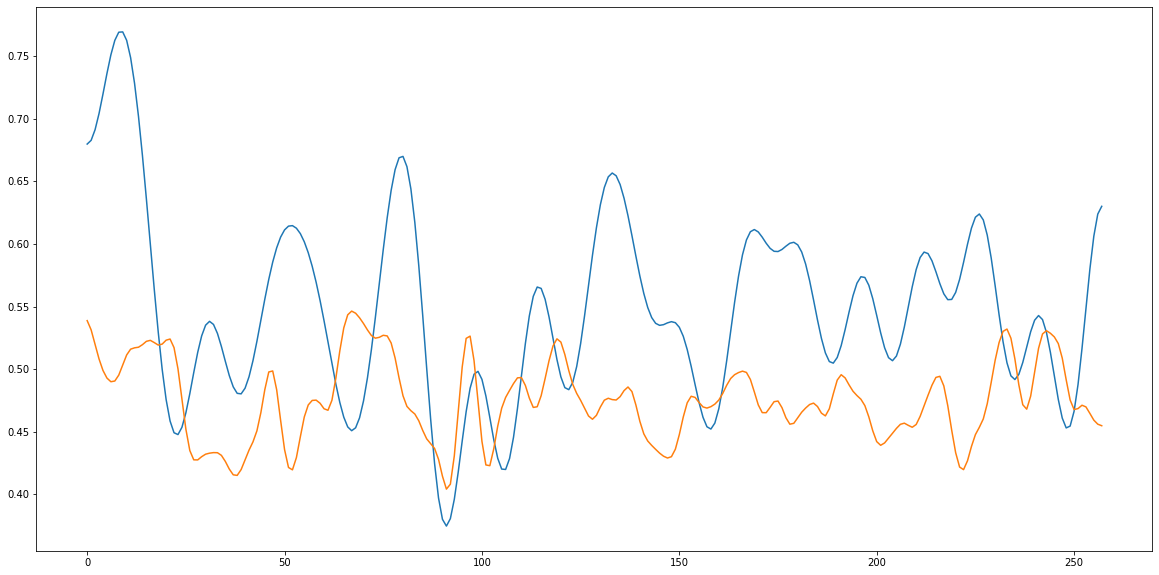

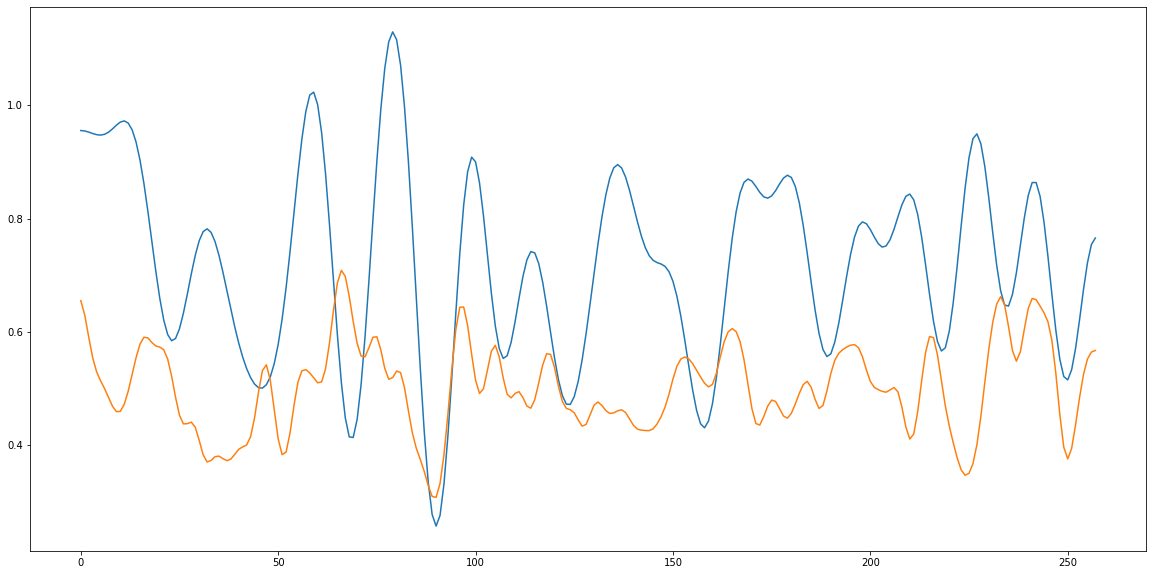

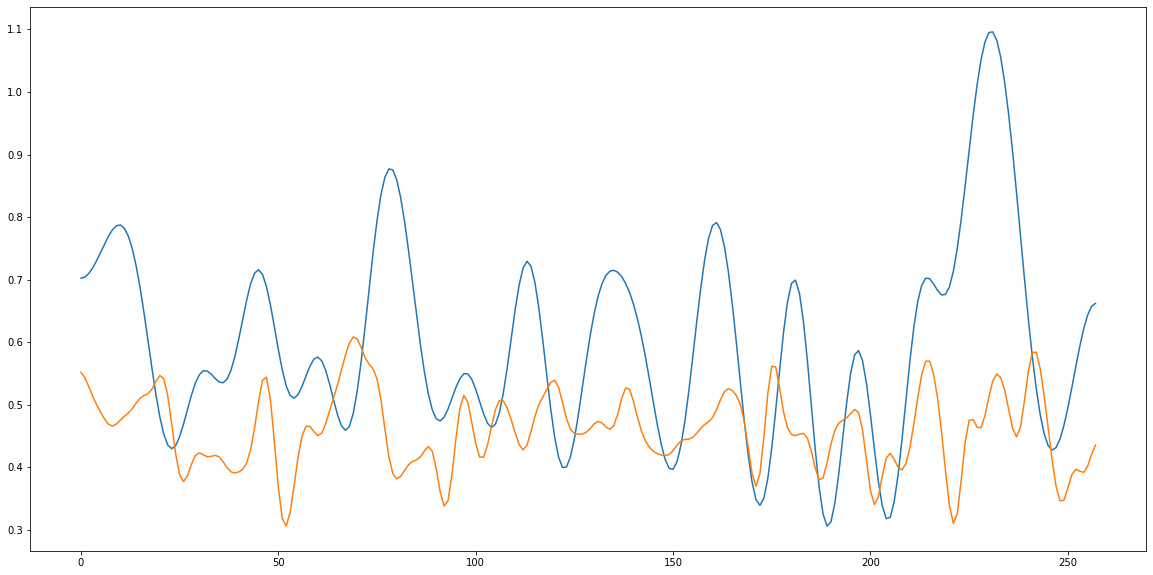

In [43]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

l = len(trump_naive_values)

plt.figure(figsize=(20,10))
plt.plot(range(l), resize(obama_naive_values, l))
plt.plot(range(l), gaussian_filter1d(trump_naive_values, sigma=2))
plt.show()

plt.figure(figsize=(20,10))
plt.plot(range(l), resize(obama_ratio_values, l))
plt.plot(range(l), gaussian_filter1d(trump_ratio_values, sigma=2))
plt.show()

plt.figure(figsize=(20,10))
plt.plot(range(l), resize(obama_hmm_values, l))
plt.plot(range(l), gaussian_filter1d(trump_hmm_values, sigma=2))
plt.show()